## Generating Audio by Predicting Amplitude of a Signal per Sample Using LSTM

In [1]:
# import audio and extract data
import numpy as np
import pandas as pd
from scipy.io.wavfile import read, write
import pydub
# deep learning modeling
from keras.layers import Dense, LSTM, LeakyReLU
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
# converting mp3 file to wav file
sound = pydub.AudioSegment.from_mp3("04 - magic-spells.mp3")
sound.export("magic-spells.wav", format="wav")
sound = pydub.AudioSegment.from_mp3("17 - two-can-win.mp3")
sound.export("two-can-win.wav", format="wav")
sound = pydub.AudioSegment.from_mp3("03 - music-in-twelve-parts-part-3.mp3")
sound.export("music-in-twelve-parts-p3.wav", format="wav")

<_io.BufferedRandom name='music-in-twelve-parts-p3.wav'>

In [4]:
# loading the wav files
# sr = sampling rate
# y = array of amplitude values
cc_sr, cc_y = read('magic-spells.wav')
jdilla_sr, jdilla_y = read('two-can-win.wav')
glass_sr, glass_y = read('music-in-twelve-parts-p3.wav')

In [42]:
# saving the original music in wav format
write('original_1.wav',
      44100, 
      pd.concat([cc_y.iloc[160001 : 400000, :], 
                jdilla_y.iloc[160001 : 400000, :], 
                glass_y.iloc[160001 : 400000, :]], axis=0).values)
# we are taking a slice from each wav and splicing them together to make a new wav that containes three sections

In [5]:
# taking only some part of the songs and converting to a dataframe
cc_y = pd.DataFrame(cc_y[0:400000, :])
jdilla_y = pd.DataFrame(jdilla_y[0:400000, :])
glass_y = pd.DataFrame(glass_y[0:400000, :])

In [7]:
# generate training dataset using the first 16000 samples of each audio
def create_train_dataset(df, look_back):
    d_X1, d_X2, d_Y1, d_Y2 = [],[],[],[]
    for i in range(len(df)-look_back-1):
        d_X1.append(df.iloc[i : i + look_back, 0].values)
        d_X2.append(df.iloc[i : i + look_back, 1].values)
        d_Y1.append(df.iloc[i + look_back, 0])
        d_Y2.append(df.iloc[i + look_back, 1])
    return np.array(d_X1), np.array(d_X2), np.array(d_Y1), np.array(d_Y2)

In [8]:
# generate a training set on parts of the music that are not in the 'original_1.wav'
X1 , X2, y1 , y2 = create_train_dataset(pd.concat([cc_y.iloc[0 : 160000, :],
                                                  jdilla_y.iloc[0 : 160000, :],
                                                  glass_y.iloc[0 : 160000, :]], axis=0), 3)

In [9]:
print(X1.shape)
print(X2.shape)
print(y1.shape)
print(y2.shape)

(479996, 3)
(479996, 3)
(479996,)
(479996,)


In [10]:
# use remaining portion of the audio data as test dataset
def create_test_dataset(df, look_back):
    d_X1, d_X2 = [], []
    for i in range(len(df)-look_back-1):
        d_X1.append(df.iloc[i : i + look_back, 0].values)
        d_X2.append(df.iloc[i : i + look_back, 1].values)
        
    return np.array(d_X1), np.array(d_X2)

In [14]:
# generate test set to test the model on the sections present in 'original.wav' in order to see how well the model can recreate the audio
test_1, test_2 = create_test_dataset(pd.concat([cc_y.iloc[160001 : 400000, :],
                                              jdilla_y.iloc[160001 : 400000, :],
                                              glass_y.iloc[160001 : 400000 :]], axis=0), 3)

In [20]:
X1 = X1.reshape((-1, 1, 3))
X2 = X2.reshape((-1, 1, 3))

In [18]:
# first model for channel 1
model_ch_1 = Sequential()
model_ch_1.add(LSTM(units=32, 
               activation='selu', 
               return_sequences=True, 
               input_shape=(None, 3)))
model_ch_1.add(LSTM(units=1, 
               activation='selu', 
               return_sequences=False, 
               input_shape=(None, 3)))
model_ch_1.compile(optimizer='SGD', 
              loss='mean_squared_error',
              metrics=['accuracy'])
model_ch_1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 32)          4608      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 136       
Total params: 4,744
Trainable params: 4,744
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model_ch_1.fit(X1, y1, 
                        epochs=20, 
                        batch_size=50)

Epoch 1/20
479996/479996 [==============================] - 49s 103us/step - loss: 1385838169.4228 - accuracy: 1.6667e-04
Epoch 2/20
479996/479996 [==============================] - 47s 99us/step - loss: 35010457.9559 - accuracy: 1.6667e-04
Epoch 3/20
479996/479996 [==============================] - 48s 99us/step - loss: 35010457.9626 - accuracy: 1.6667e-04
Epoch 4/20
479996/479996 [==============================] - 48s 100us/step - loss: 35010457.9814 - accuracy: 1.6667e-04
Epoch 5/20
479996/479996 [==============================] - 49s 101us/step - loss: 35010457.9732 - accuracy: 1.6667e-04
Epoch 6/20
479996/479996 [==============================] - 50s 104us/step - loss: 35010457.8916 - accuracy: 1.6667e-04
Epoch 7/20
479996/479996 [==============================] - 54s 113us/step - loss: 35010457.9616 - accuracy: 1.6667e-04
Epoch 8/20
479996/479996 [==============================] - 50s 103us/step - loss: 35010457.9487 - accuracy: 1.6667e-04
Epoch 9/20
479996/479996 [==============

dict_keys(['loss', 'accuracy'])


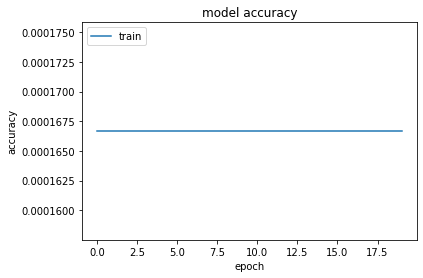

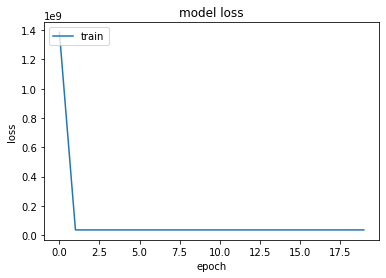

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_LSTM_training_loss')
plt.show()

Absolutely embarassing - lets train for the data on channel 2 for consistency

In [23]:
# first model for channel 2
model_ch_2 = Sequential()
model_ch_2.add(LSTM(units=32, 
               activation='selu', 
               return_sequences=True, 
               input_shape=(None, 3)))
model_ch_2.add(LSTM(units=1, 
               activation='selu', 
               return_sequences=False, 
               input_shape=(None, 3)))
model_ch_2.compile(optimizer='SGD', 
              loss='mean_squared_error',
              metrics=['accuracy'])
model_ch_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 32)          4608      
_________________________________________________________________
lstm_6 (LSTM)                (None, 1)                 136       
Total params: 4,744
Trainable params: 4,744
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model_ch_1.fit(X2, y2, 
                        epochs=20, 
                        batch_size=50)

Epoch 1/20
479996/479996 [==============================] - 57s 118us/step - loss: 33749981.1169 - accuracy: 1.5208e-04
Epoch 2/20
479996/479996 [==============================] - 54s 112us/step - loss: 33749981.1532 - accuracy: 1.5208e-04
Epoch 3/20
479996/479996 [==============================] - 50s 105us/step - loss: 33749981.1757 - accuracy: 1.5208e-04
Epoch 4/20
479996/479996 [==============================] - 49s 102us/step - loss: 33749981.1818 - accuracy: 1.5208e-04
Epoch 5/20
479996/479996 [==============================] - 49s 101us/step - loss: 33749981.1240 - accuracy: 1.5208e-04
Epoch 6/20
479996/479996 [==============================] - 50s 105us/step - loss: 33749981.1634 - accuracy: 1.5208e-04
Epoch 7/20
479996/479996 [==============================] - 49s 102us/step - loss: 33749981.1685 - accuracy: 1.5208e-04
Epoch 8/20
479996/479996 [==============================] - 53s 110us/step - loss: 33749981.1399 - accuracy: 1.5208e-04
Epoch 9/20
479996/479996 [==============

dict_keys(['loss', 'accuracy'])


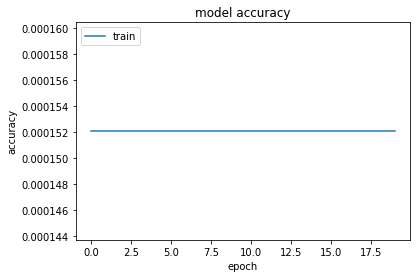

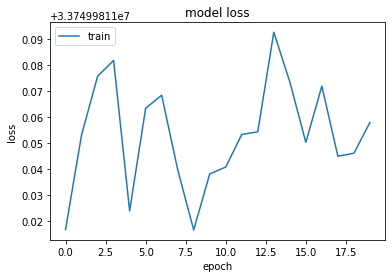

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_LSTM_training_loss')
plt.show()

Utterly horrible!

Now I'm just interested what it would produce with its predictions

In [26]:
model_ch_1.save('model_ch_1.h5')
model_ch_2.save('model_ch_2.h5')
model_ch_1 = load_model('model_ch_1.h5')
model_ch_2 = load_model('model_ch_2.h5')
pred_model_ch_1 = model_ch_1.predict(test_1.reshape(-1, 1, 3))
pred_model_ch_2 = model_ch_2.predict(test_2.reshape(-1, 1, 3))
write('output_1.wav', 
       44100, 
       pd.concat([pd.DataFrame(pred_model_ch_1.astype('int16')), pd.DataFrame(pred_model_ch_2.astype('int16'))], axis=1).values)

In [27]:
# second model for channel 1
model_2ch_1 = Sequential()
model_2ch_1.add(LSTM(units=100, 
                    activation='relu', 
                    input_shape=(None, 3)))
model_2ch_1.add(Dense(units=50, 
                      activation='relu'))
model_2ch_1.add(Dense(units=25, 
                      activation='relu'))
model_2ch_1.add(Dense(units=12, 
                      activation='relu'))
model_2ch_1.add(Dense(units=1, 
                      activation='relu'))
model_2ch_1.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
model_2ch_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 48,250
Trainable params: 48,250
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model_2ch_1.fit(X1, y1, 
                epochs=20, 
                batch_size=100)

Epoch 1/20
479996/479996 [==============================] - 34s 70us/step - loss: 17837441.8174 - accuracy: 9.7501e-04
Epoch 2/20
479996/479996 [==============================] - 35s 72us/step - loss: 17712259.2190 - accuracy: 9.6876e-04
Epoch 3/20
479996/479996 [==============================] - 36s 74us/step - loss: 17708389.6329 - accuracy: 8.6667e-04
Epoch 4/20
479996/479996 [==============================] - 33s 68us/step - loss: 17708083.9120 - accuracy: 9.3542e-04
Epoch 5/20
479996/479996 [==============================] - 32s 67us/step - loss: 17705025.9893 - accuracy: 0.0010
Epoch 6/20
479996/479996 [==============================] - 35s 73us/step - loss: 17704447.0463 - accuracy: 0.0011
Epoch 7/20
479996/479996 [==============================] - 33s 68us/step - loss: 17703812.6074 - accuracy: 0.0011
Epoch 8/20
479996/479996 [==============================] - 32s 66us/step - loss: 17703512.8498 - accuracy: 0.0011
Epoch 9/20
479996/479996 [==============================] - 32s 

dict_keys(['loss', 'accuracy'])


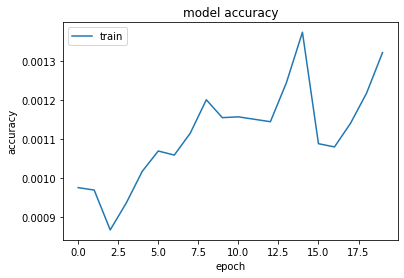

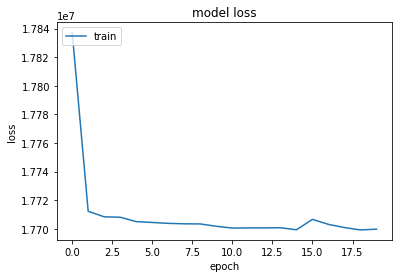

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_LSTM_training_loss')
plt.show()

In [30]:
# second model for channel 2
model_2ch_2 = Sequential()
model_2ch_2.add(LSTM(units=100, 
                    activation='relu', 
                    input_shape=(None, 3)))
model_2ch_2.add(Dense(units=50, 
                      activation='relu'))
model_2ch_2.add(Dense(units=25, 
                      activation='relu'))
model_2ch_2.add(Dense(units=12, 
                      activation='relu'))
model_2ch_2.add(Dense(units=1, 
                      activation='relu'))
model_2ch_2.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
model_2ch_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 48,250
Trainable params: 48,250
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model_2ch_2.fit(X2, y2, 
                epochs=20, 
                batch_size=100)

Epoch 1/20
479996/479996 [==============================] - 33s 68us/step - loss: 17348457.6382 - accuracy: 6.6667e-04
Epoch 2/20
479996/479996 [==============================] - 31s 65us/step - loss: 17253324.5387 - accuracy: 6.6876e-04
Epoch 3/20
479996/479996 [==============================] - 30s 63us/step - loss: 17246427.0119 - accuracy: 6.6876e-04
Epoch 4/20
479996/479996 [==============================] - 30s 62us/step - loss: 17241560.2870 - accuracy: 6.7917e-04
Epoch 5/20
479996/479996 [==============================] - 30s 63us/step - loss: 17240808.8944 - accuracy: 6.6667e-04
Epoch 6/20
479996/479996 [==============================] - 30s 63us/step - loss: 17241489.2446 - accuracy: 7.4376e-04
Epoch 7/20
479996/479996 [==============================] - 31s 64us/step - loss: 17242422.8191 - accuracy: 7.1251e-04
Epoch 8/20
479996/479996 [==============================] - 34s 70us/step - loss: 17241344.3001 - accuracy: 6.9167e-04
Epoch 9/20
479996/479996 [======================

dict_keys(['loss', 'accuracy'])


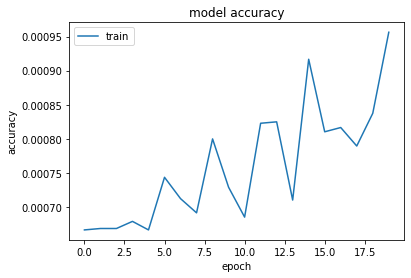

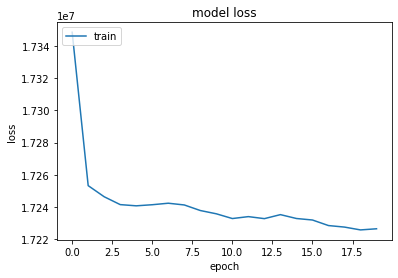

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_2_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_2_2_LSTM_training_loss')
plt.show()

In [33]:
model_2ch_1.save('model_2ch_1.h5')
model_2ch_2.save('model_2ch_2.h5')
model_2ch_1 = load_model('model_2ch_1.h5')
model_2ch_2 = load_model('model_2ch_2.h5')
pred_model_2ch_1 = model_2ch_1.predict(test_1.reshape(-1, 1, 3))
pred_model_2ch_2 = model_2ch_2.predict(test_2.reshape(-1, 1, 3))
write('output_2.wav', 
       44100, 
       pd.concat([pd.DataFrame(pred_model_2ch_1.astype('int16')), pd.DataFrame(pred_model_2ch_2.astype('int16'))], axis=1).values)

In [34]:
# third model for channel 1
model_3ch_1 = Sequential()
model_3ch_1.add(LSTM(units=100, 
                    activation='linear', 
                    input_shape=(None, 3)))
model_3ch_1.add(LeakyReLU())
model_3ch_1.add(Dense(units=50, 
                      activation='linear'))
model_3ch_1.add(LeakyReLU())
model_3ch_1.add(Dense(units=25, 
                      activation='linear'))
model_3ch_1.add(LeakyReLU())
model_3ch_1.add(Dense(units=12, 
                      activation='linear'))
model_3ch_1.add(LeakyReLU())
model_3ch_1.add(Dense(units=1, 
                      activation='linear'))
model_3ch_1.add(LeakyReLU())
model_3ch_1.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
model_3ch_1.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               41600     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)               

In [35]:
history = model_3ch_1.fit(X1, y1, 
                epochs=20, 
                batch_size=100)

Epoch 1/20
479996/479996 [==============================] - 38s 79us/step - loss: 622424.8032 - accuracy: 0.0017
Epoch 2/20
479996/479996 [==============================] - 33s 70us/step - loss: 362309.4980 - accuracy: 0.0020
Epoch 3/20
479996/479996 [==============================] - 35s 74us/step - loss: 356970.1012 - accuracy: 0.0019
Epoch 4/20
479996/479996 [==============================] - 34s 72us/step - loss: 351463.0851 - accuracy: 0.0019
Epoch 5/20
479996/479996 [==============================] - 34s 70us/step - loss: 351227.8189 - accuracy: 0.0019
Epoch 6/20
479996/479996 [==============================] - 35s 73us/step - loss: 349025.0755 - accuracy: 0.0020
Epoch 7/20
479996/479996 [==============================] - 33s 68us/step - loss: 345641.2469 - accuracy: 0.0020
Epoch 8/20
479996/479996 [==============================] - 37s 76us/step - loss: 345802.7586 - accuracy: 0.0019
Epoch 9/20
479996/479996 [==============================] - 33s 68us/step - loss: 343937.3435 - 

dict_keys(['loss', 'accuracy'])


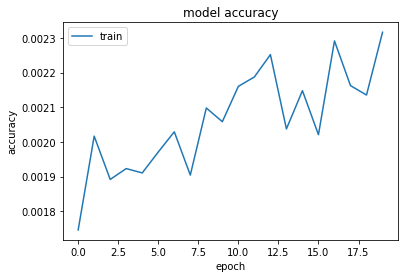

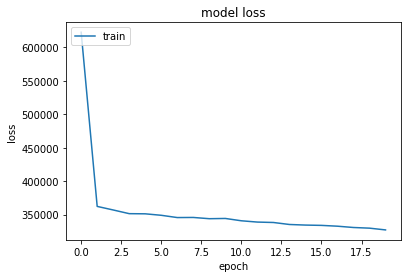

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_3_1_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_3_1_LSTM_training_loss')
plt.show()

In [37]:
# third model for channel 2
model_3ch_2 = Sequential()
model_3ch_2.add(LSTM(units=100, 
                    activation='linear', 
                    input_shape=(None, 3)))
model_3ch_2.add(LeakyReLU())
model_3ch_2.add(Dense(units=50, 
                      activation='linear'))
model_3ch_2.add(LeakyReLU())
model_3ch_2.add(Dense(units=25, 
                      activation='linear'))
model_3ch_2.add(LeakyReLU())
model_3ch_2.add(Dense(units=12, 
                      activation='linear'))
model_3ch_2.add(LeakyReLU())
model_3ch_2.add(Dense(units=1, 
                      activation='linear'))
model_3ch_2.add(LeakyReLU())
model_3ch_2.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
model_3ch_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               41600     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)               

In [38]:
history = model_3ch_2.fit(X2, y2, 
                epochs=20, 
                batch_size=100)

Epoch 1/20
479996/479996 [==============================] - 35s 72us/step - loss: 999348.9689 - accuracy: 0.0012
Epoch 2/20
479996/479996 [==============================] - 33s 70us/step - loss: 672246.1115 - accuracy: 0.0013
Epoch 3/20
479996/479996 [==============================] - 34s 72us/step - loss: 666399.3525 - accuracy: 0.0013
Epoch 4/20
479996/479996 [==============================] - 33s 68us/step - loss: 665103.8125 - accuracy: 0.0012
Epoch 5/20
479996/479996 [==============================] - 34s 71us/step - loss: 662470.9331 - accuracy: 0.0013
Epoch 6/20
479996/479996 [==============================] - 34s 71us/step - loss: 660968.2070 - accuracy: 0.0014
Epoch 7/20
479996/479996 [==============================] - 33s 69us/step - loss: 654804.6829 - accuracy: 0.0013
Epoch 8/20
479996/479996 [==============================] - 33s 69us/step - loss: 652578.2546 - accuracy: 0.0014
Epoch 9/20
479996/479996 [==============================] - 34s 71us/step - loss: 648610.8802 - 

dict_keys(['loss', 'accuracy'])


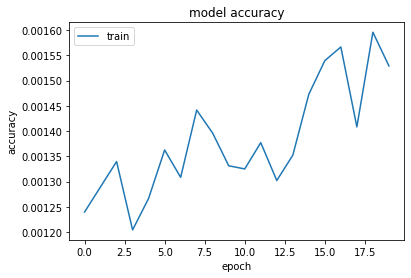

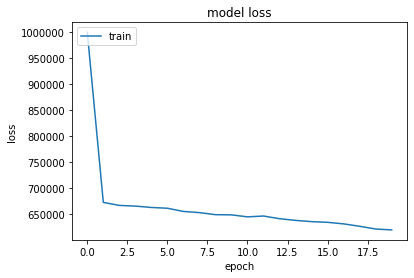

In [39]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_3_2_LSTM_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('M9_3_2_LSTM_training_loss')
plt.show()

In [40]:
model_3ch_1.save('model_3ch_1.h5')
model_3ch_2.save('model_3ch_2.h5')
model_3ch_1 = load_model('model_3ch_1.h5')
model_3ch_2 = load_model('model_3ch_2.h5')
pred_model_3ch_1 = model_3ch_1.predict(test_1.reshape(-1, 1, 3))
pred_model_3ch_2 = model_3ch_2.predict(test_2.reshape(-1, 1, 3))
write('output_3.wav', 
       44100, 
       pd.concat([pd.DataFrame(pred_model_3ch_1.astype('int16')), pd.DataFrame(pred_model_3ch_2.astype('int16'))], axis=1).values)

Examining the Wav Forms

In [43]:
import librosa, librosa.display

In [48]:
original_y, sr = librosa.load('original_1.wav')
output_1_y, sr = librosa.load('output_1.wav')
output_2_y, sr = librosa.load('output_2.wav')
output_3_y, sr = librosa.load('output_3.wav')

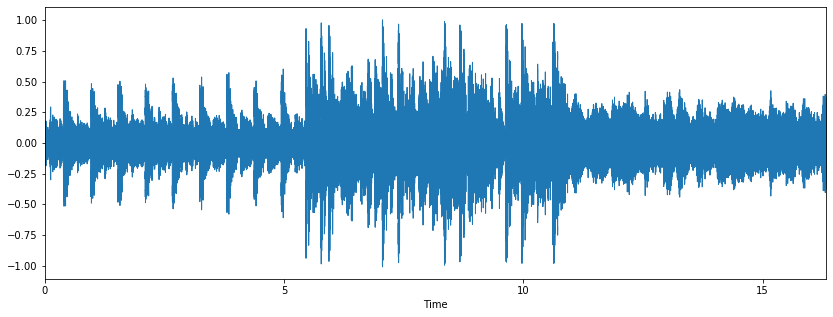

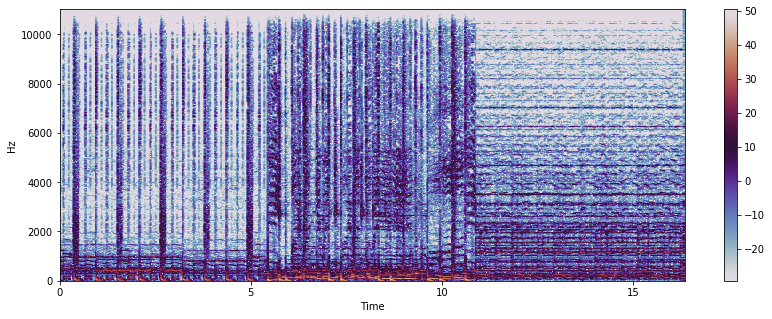

In [56]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(original_y, sr=sr)
X = librosa.stft(original_y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, 
                        sr=sr, 
                        x_axis='time', 
                        y_axis='hz',
                        cmap='twilight')
plt.colorbar()

Here is the amplitude and frequency ranges of original wav 

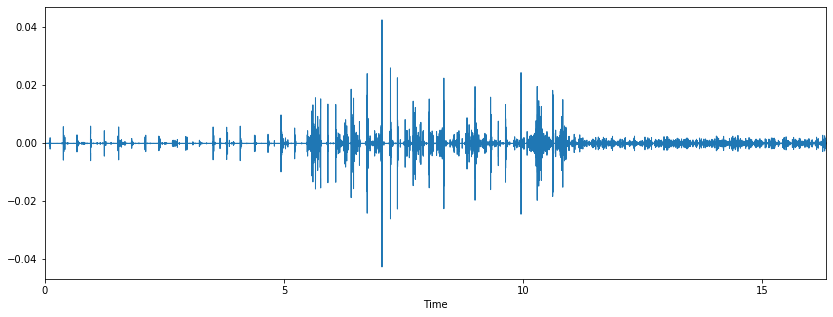

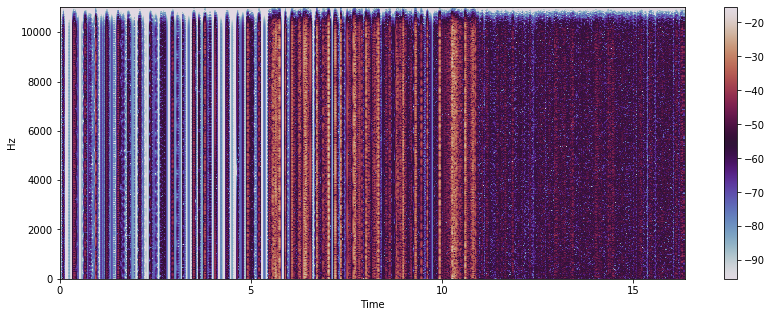

In [57]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(output_1_y, sr=sr)
X = librosa.stft(output_1_y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, 
                        sr=sr, 
                        x_axis='time', 
                        y_axis='hz',
                        cmap='twilight')
plt.colorbar()

Here the output sounds like static and crackles. The model does a terrible job recreating the audio.

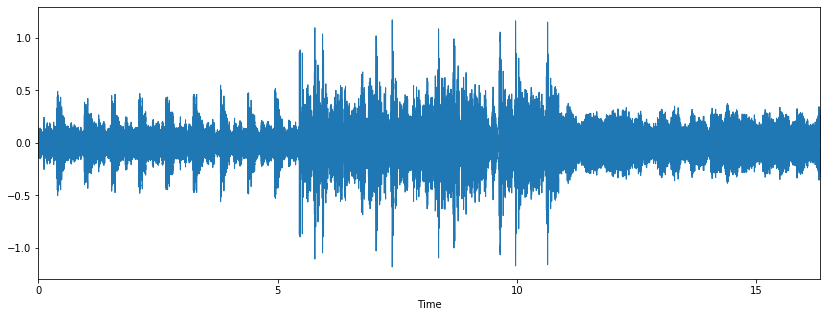

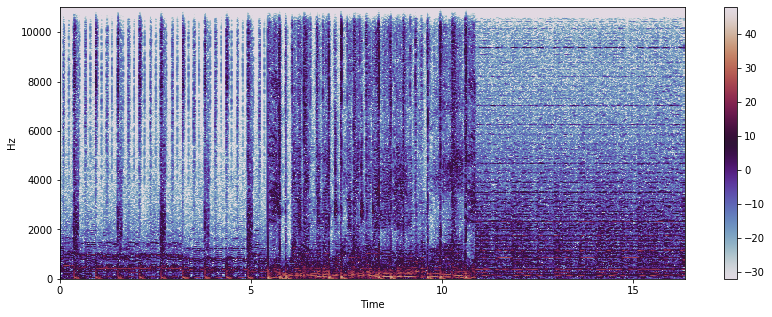

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(output_2_y, sr=sr)
X = librosa.stft(output_2_y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, 
                        sr=sr, 
                        x_axis='time', 
                        y_axis='hz',
                        cmap='twilight')
plt.colorbar()

Here the output resembles the music, but the model's accuracy at predicting the volume of each sample is still off. The audio sounds blown out.

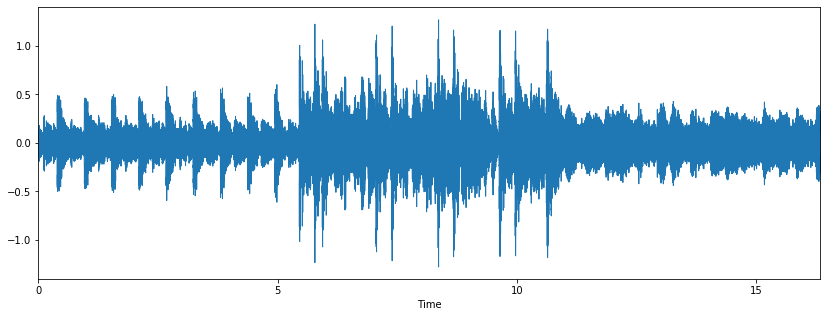

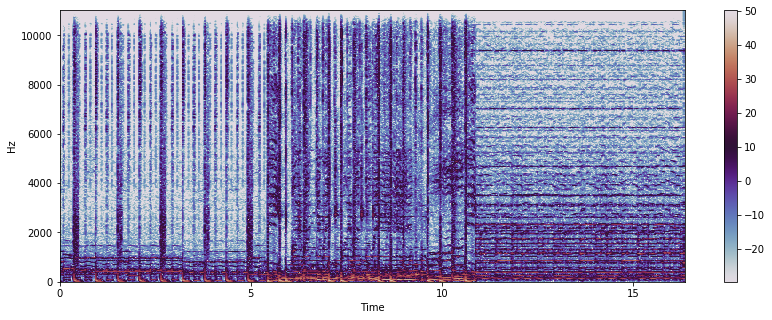

In [59]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(output_3_y, sr=sr)
X = librosa.stft(output_3_y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, 
                        sr=sr, 
                        x_axis='time', 
                        y_axis='hz',
                        cmap='twilight')
plt.colorbar()

Here the the model does a fairly good job. We can see in the spectrograp that there are more accurate details in the resolution of the frequencies